In [1]:
import copy
import json
import os
import pathlib
import sys
import random
import pickle
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

# shap displays NumbaDeprecationWarning when importing -- supress them
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

import shap
import torch
from torch import Tensor, sigmoid

# logging.basicConfig(level=logging.INFO)

# correct path to repository root
REPOSITORY_ROOT = os.path.join(os.getcwd(), "..", "..", "..")
sys.path.append(REPOSITORY_ROOT)

from nebula import PEDynamicFeatureExtractor
from nebula.models.attention import TransformerEncoderOptionalEmbedding
from nebula.preprocessing import JSONTokenizerNaive

from nebula.misc.plots import set_size

from nebula.misc import fix_random_seed
fix_random_seed(0)


def compute_score(llm, x, verbose=True):
    logit = llm(x)
    prob = sigmoid(logit)
    if verbose:
        print(f"\n[!!!] Probability of being malicious: {prob.item():.3f} | Logit: {logit.item():.3f}")
    return prob.item()


def load_tokenizer():
    with open(os.path.join(REPOSITORY_ROOT, "nebula", "objects",
                           "speakeasy_whitespace_50000_vocab.json")) as f:
        vocab = json.load(f)

    tokenizer = JSONTokenizerNaive(
        vocab_size=len(vocab),
        seq_len=512,
        vocab=vocab
    )
    return tokenizer


def tokenize_sample(report_path, encode=True):
    extractor = PEDynamicFeatureExtractor()
    filtered_report = extractor.filter_and_normalize_report(report_path)
    tokenizer = load_tokenizer()
    tokenized_report = tokenizer.tokenize(filtered_report)
    if encode:
        encoded_report = tokenizer.encode(tokenized_report, pad=True, tokenize=False)
        x = Tensor(encoded_report).long()
        return x
    else:
        return tokenized_report


def embed(llm_model, report, device="cpu"):
    src = tokenize_sample(report)
    s = llm_model.split(src)
    s = s.to(device)
    e = llm_model.embed(s)
    return e


def plot_shap_values(shap_values: np.ndarray, name: str):
    shap_values = shap_values.mean(axis=2)
    pos_idx = shap_values[0] >= 0
    neg_index = shap_values[0] < 0
    pos_shap = copy.deepcopy(shap_values)[0]
    pos_shap[neg_index] = 0
    neg_shap = copy.deepcopy(shap_values)[0]
    neg_shap[pos_idx] = 0
    x = range(512)
    plt.bar(x, pos_shap)
    plt.bar(x, neg_shap)
    plt.title(name)
    plt.show()


def load_model(skip_embedding=False):
    pretrained_model = os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_whitespace_50000_torch.model")
    with open(os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_whitespace_50000_vocab.json")) as f:
        vocab = json.load(f)
    model_config = {
        "vocab_size": len(vocab),
        "maxlen": 512,
        "chunk_size": 64,  # input splitting to chunks
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1,  # binary classification
        "hiddenNeurons": [64],  # classifier ffnn dims
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True,
        "skip_embedding": skip_embedding
    }
    state_dict = torch.load(pretrained_model, map_location='cpu')
    llm = TransformerEncoderOptionalEmbedding(**model_config)
    llm.load_state_dict(state_dict)
    llm.eval()
    return llm


In [2]:
def generalize_shap_values(reports, model, embed_baseline, threshold=0.5, verbose=True, clean=False):
    explanations_tp = {}
    explanations_fn = {}
    if isinstance(reports, pathlib.Path):
        generator = reports.glob("*.json")
    if isinstance(reports, list):
        generator = [x for x in reports if x.endswith("json")]
    tp_idx = 0
    fn_idx = 0
    length = len(generator)
    for i, report in enumerate(generator):
        if clean:
            print(f"[*] Processing: {i}/{length} | TNs: {tp_idx} | FPs: {fn_idx}", end="\r")
        else:
            print(f"[*] Processing: {i}/{length} | TPs: {tp_idx} | FNs: {fn_idx}", end="\r")
        try:
            name = report.name
        except AttributeError:
            name = report
        if verbose:
            print(name)
        x_embed = embed(model, str(report))
        prob = compute_score(model, x_embed, verbose=verbose)
        explainer = shap.GradientExplainer(model_no_embed, data=embed_baseline)
        explanations = explainer.shap_values(x_embed, nsamples=50)
        token_idxs = tokenize_sample(str(report), encode=True)
        if clean:
            if prob < threshold:
                tp_idx += 1
                explanations_tp[name] = (explanations, token_idxs)
            else:
                fn_idx += 1
                explanations_fn[name] = (explanations, token_idxs)
        else:
            if prob > threshold:
                tp_idx += 1
                explanations_tp[name] = (explanations, token_idxs)
            else:
                fn_idx += 1
                explanations_fn[name] = (explanations, token_idxs)
    print() # newline to preserve processing output
    return explanations_tp, explanations_fn


def aggregate_values(data, vocab, aggregate="mean", limit=1000, name=""):
    assert aggregate in ["mean", "sum"]
    aggregate_file = f"explanations_{name}_agg_{aggregate}_lim_{limit}.json"
    
    if os.path.exists(aggregate_file):
        print(f"[!] Loading aggregated explanations from '{aggregate_file}'...")
        with open(aggregate_file, "r") as f:
            output_dict = json.load(f)
        return output_dict
    
    # Initialize an output dictionary with vocab keys and values set to zero
    output_dict = {k: [] for k in vocab.keys()}

    # Iterate through each name in data
    for values, token_idxs in tqdm(data.values()):
        # Average the shap values across the embedding dimension
        values = values.mean(axis=2).squeeze().tolist()
        token_idxs = token_idxs.squeeze().tolist()
        for v, idx in zip(values, token_idxs):
            # For each token index, find the corresponding token in vocab
            token = [k for k, i in vocab.items() if i == idx][0]
            # Add the value to the output_dict for that token
            output_dict[token].append(v)
    
    if aggregate == "mean":
        for k, v in output_dict.items():
            output_dict[k] = np.mean(v)
    elif aggregate == "sum":
        for k, v in output_dict.items():
            output_dict[k] = np.sum(v)

    # write output dict as json
    with open(aggregate_file, "w") as f:
        json.dump(output_dict, f, indent=4)
    
    return output_dict


def gather_explanations(folder, model_no_embed, x_embed_baseline, limit=1000):
    # NOTE: limit=1000 files takes ~35 mins
    ware_type = folder.split("\\")[-1].replace("report_", "")
    print(f"[!] Working on '{ware_type}'...")

    files = [os.path.join(folder, x) for x in os.listdir(folder)]
    # randomly subsample 'limit' files
    files_limited = random.sample(files, min(limit, len(files)))

    if ware_type == "clean":
        clean = True
        explanations_t_file = f"explanations_tn_{ware_type}_lim_{limit}.pickle"
        explanations_f_file = f"explanations_fp_{ware_type}_lim_{limit}.pickle"
    else:
        clean = False
        explanations_t_file = f"explanations_tp_{ware_type}_lim_{limit}.pickle"
        explanations_f_file = f"explanations_fn_{ware_type}_lim_{limit}.pickle"

    if os.path.exists(explanations_t_file) and os.path.exists(explanations_f_file):
        print(f"[!] Loading explanations from '{explanations_t_file}' and '{explanations_f_file}'...")
        with open(explanations_t_file, "rb") as f:
            explanations_t = pickle.load(f)
        with open(explanations_f_file, "rb") as f:
            explanations_f = pickle.load(f)
    else:
        explanations_t, explanations_f = generalize_shap_values(
            files_limited,
            model_no_embed,
            x_embed_baseline,
            verbose=False,
            clean=clean)
        # dump as pickle
        with open(explanations_t_file, "wb") as f:
            pickle.dump(explanations_t, f)
        with open(explanations_f_file, "wb") as f:
            pickle.dump(explanations_f, f)
        
    return explanations_t, explanations_f

### Loading Pretrained Objects

In [3]:
model = load_model()
model_no_embed = load_model(skip_embedding=True)
tokenizer = load_tokenizer()

malware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "malware"))
goodware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "goodware"))

baseline_report = os.path.join(REPOSITORY_ROOT, r"emulation", "report_baseline.json")

x_baseline = tokenize_sample(baseline_report)
x_embed_baseline = embed(model, baseline_report)

In [7]:
LIMIT = 1000

testset_folder = os.path.join(REPOSITORY_ROOT, r"data\windows_emulation_testset")
for folder in os.listdir(testset_folder):
    if "syswow64" in folder:
        continue
    tp, fn = gather_explanations(os.path.join(testset_folder, folder), model_no_embed, x_embed_baseline, limit=LIMIT)
    tp_file = f"tn_{folder.replace('report_', '')}" if (folder.endswith("clean")) else f"tp_{folder.replace('report_', '')}"
    aggregate_values(tp, tokenizer.vocab, aggregate="mean", limit=LIMIT, name=tp_file) # ~10 min for 700 explanations
    fn_file = f"fp_{folder.replace('report_', '')}" if (folder.endswith("clean")) else f"fn_{folder.replace('report_', '')}"
    aggregate_values(fn, tokenizer.vocab, aggregate="mean", limit=LIMIT, name=fn_file)
    print() # to add gap between runs

[!] Working on 'backdoor'...
[!] Loading explanations from 'explanations_tp_backdoor_lim_1000.pickle' and 'explanations_fn_backdoor_lim_1000.pickle'...
[!] Loading aggregated explanations from 'explanations_tp_backdoor_agg_mean_lim_1000.json'...
[!] Loading aggregated explanations from 'explanations_fn_backdoor_agg_mean_lim_1000.json'...

[!] Working on 'clean'...
[!] Loading explanations from 'explanations_tn_clean_lim_1000.pickle' and 'explanations_fp_clean_lim_1000.pickle'...
[!] Loading aggregated explanations from 'explanations_tn_clean_agg_mean_lim_1000.json'...
[!] Loading aggregated explanations from 'explanations_fp_clean_agg_mean_lim_1000.json'...

[!] Working on 'coinminer'...
[!] Loading explanations from 'explanations_tp_coinminer_lim_1000.pickle' and 'explanations_fn_coinminer_lim_1000.pickle'...
[!] Loading aggregated explanations from 'explanations_tp_coinminer_agg_mean_lim_1000.json'...
[!] Loading aggregated explanations from 'explanations_fn_coinminer_agg_mean_lim_10


[!] explanations_tn_clean_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


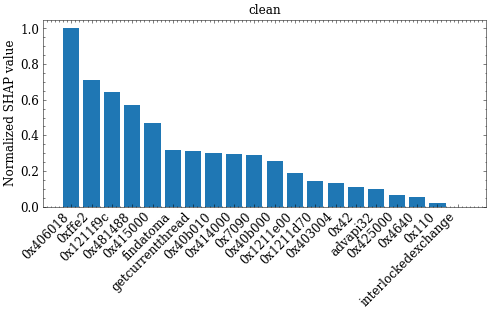


[!] explanations_tn_windows_syswow64_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


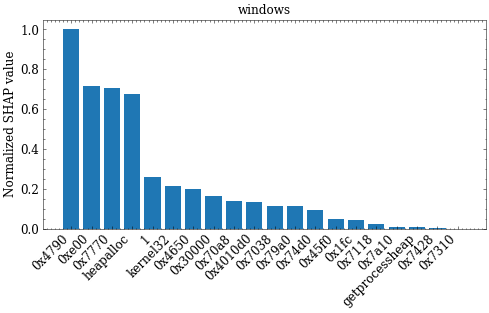


[!] explanations_tp_backdoor_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


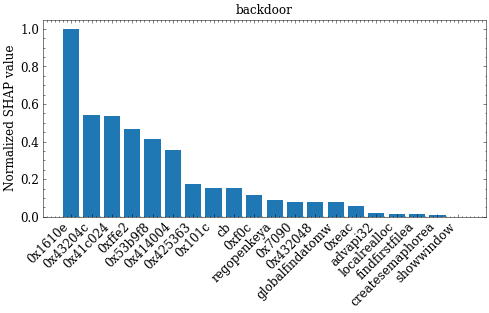


[!] explanations_tp_coinminer_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


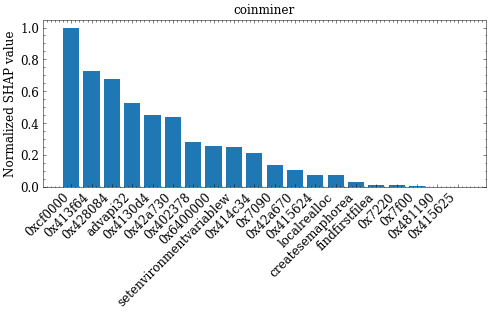


[!] explanations_tp_dropper_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


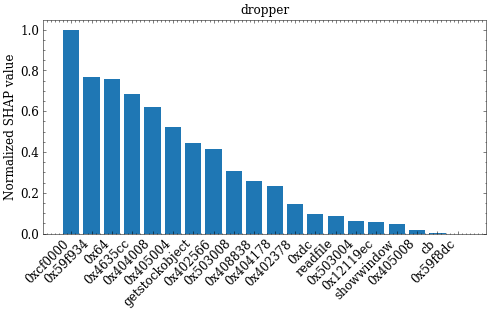


[!] explanations_tp_keylogger_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


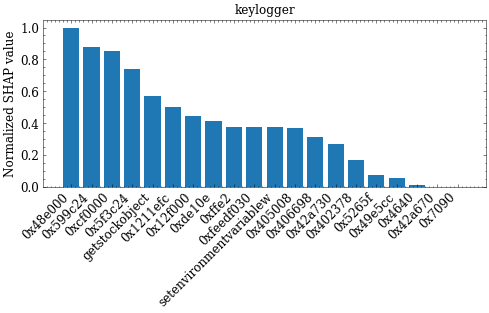


[!] explanations_tp_ransomware_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


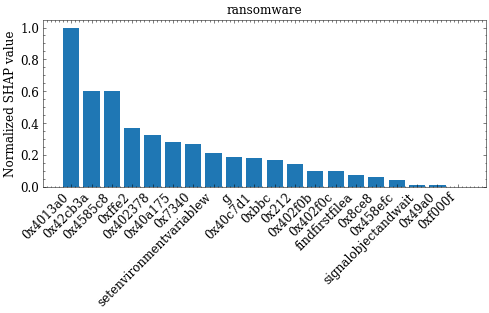


[!] explanations_tp_rat_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


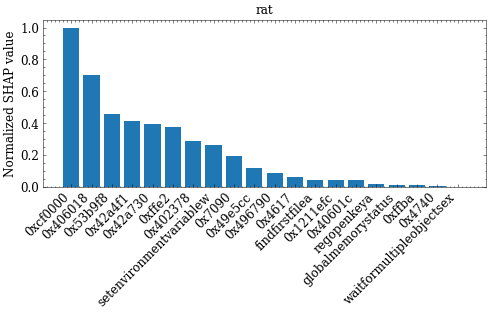


[!] explanations_tp_trojan_agg_mean_lim_1000.json


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


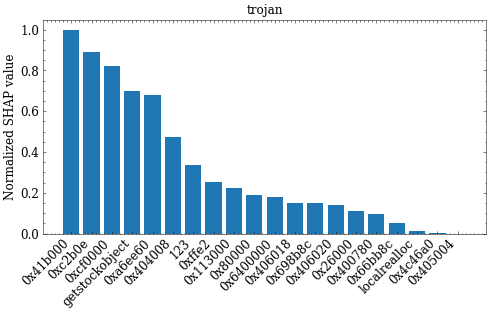

In [12]:
TOP = 20

def plot_top_features(agg_shap_tokens_tp, skip=0, color="tab:blue"):
    for k, v in agg_shap_tokens_tp.items():
        if np.isnan(v):
            agg_shap_tokens_tp[k] = 0
    top_tp_features = sorted(agg_shap_tokens_tp.items(), key=lambda x: x[1], reverse=True)[:TOP]

    x = [x[0] for x in top_tp_features][skip:]
    y = np.array([x[1] for x in top_tp_features][skip:])
    # normalize y to be within [0, 1]
    y = (y - y.min()) / (y.max() - y.min())

    fig, ax = plt.subplots(figsize=set_size())
    ax.bar(x, y, color=color)
    ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
    ax.set_yticklabels([f"{x:.1f}" for x in ax.get_yticks()], fontsize=12)
    _ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
    plt.tight_layout()
    return ax


for agg_shap_tokens_tp_file in [x for x in os.listdir(".") if x.startswith("explanations_t") and x.endswith(".json")]:
    print(f"\n[!] {agg_shap_tokens_tp_file}")
    with open(agg_shap_tokens_tp_file, "r") as f:
        agg_shap_tokens_tp = json.load(f)
    
    ax = plot_top_features(agg_shap_tokens_tp)
    title = agg_shap_tokens_tp_file.replace("explanations_t", "").split("_")[1]
    ax.set_title(title)
    plt.show()

### Aggregating tokens over all the malware types

In [19]:
agg_malware_tp = {}

for agg_shap_tokens_tp_file in [x for x in os.listdir(".") if x.startswith("explanations_tp") and x.endswith(".json")]:
    with open(agg_shap_tokens_tp_file, "r") as f:
        agg_shap_tokens_tp = json.load(f)
    
    for k, v in agg_shap_tokens_tp.items():
        if k not in agg_malware_tp:
            agg_malware_tp[k] = []
        agg_malware_tp[k].append(v)
    
agg_malware_tp = {k: np.mean(v) for k, v in agg_malware_tp.items()}
# fill nan in agg_malware_tp
for k, v in agg_malware_tp.items():
    if np.isnan(v):
        agg_malware_tp[k] = 0
agg_malware_tp_sorted = {k: v for k, v in sorted(agg_malware_tp.items(), key=lambda x: x[1], reverse=True)}

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


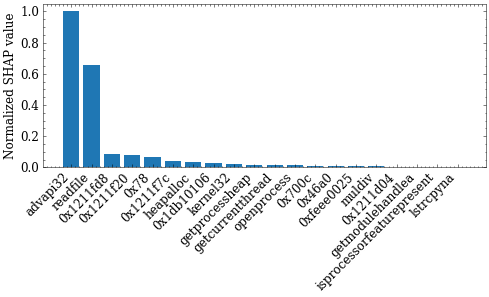

In [20]:
ax = plot_top_features(agg_malware_tp, skip=0)

### Same for clean software

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


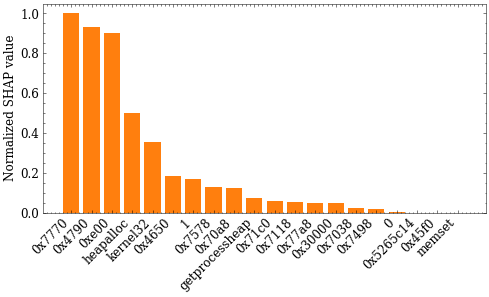

In [21]:
agg_clean_tn = {}

for agg_shap_tokens_tn_file in [x for x in os.listdir(".") if x.startswith("explanations_tn") and x.endswith(".json")]:
    with open(agg_shap_tokens_tn_file, "r") as f:
        agg_shap_tokens_tn = json.load(f)
    
    for k, v in agg_shap_tokens_tn.items():
        if k not in agg_clean_tn:
            agg_clean_tn[k] = []
        agg_clean_tn[k].append(v)

agg_clean_tn = {k: np.mean(v) for k, v in agg_clean_tn.items()}
# fill nan in agg_clean_tn
for k, v in agg_clean_tn.items():
    if np.isnan(v):
        agg_clean_tn[k] = 0
agg_clean_tn_sorted = {k: v for k, v in sorted(agg_clean_tn.items(), key=lambda x: x[1], reverse=True)}

ax = plot_top_features(agg_clean_tn_sorted, skip=0, color="tab:orange")

### Diverging bar plot

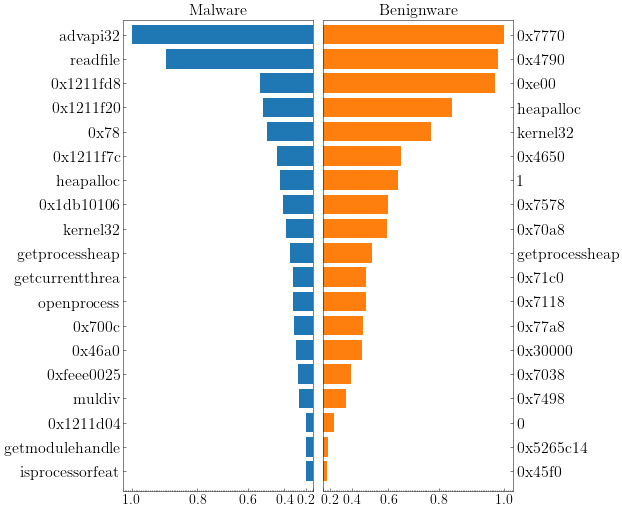

In [27]:
plt.style.use(['science'])
# plt.style.use(['science', 'no-latex'])

def power_transform(x, alpha=0.5):
    return np.power(x, alpha)

def inverse_power_transform(y, alpha=0.5):
    return np.power(y, 1/alpha)

# Extract and normalize positive class data
FEATURE_LIM = 15 # chars
SKIP = 0
TOP = 20
x_pos = [k[:FEATURE_LIM] for k in list(agg_malware_tp_sorted.keys())][SKIP:][:TOP]
y_pos = np.array([v for v in list(agg_malware_tp_sorted.values())][SKIP:])[:TOP]
y_pos = (y_pos - y_pos.min()) / (y_pos.max() - y_pos.min()) # normalize
y_pos = power_transform(y_pos)

# Extract and normalize negative class data
x_neg = [k[:FEATURE_LIM] for k in agg_clean_tn_sorted.keys()][SKIP:][:TOP]
y_neg = np.array([v for v in agg_clean_tn_sorted.values()][SKIP:])[:TOP]
y_neg = (y_neg - y_neg.min()) / (y_neg.max() - y_neg.min())
y_neg = power_transform(y_neg)

# Create a figure and axis
sizes = set_size()
fig, axs = plt.subplots(1, 2, figsize=(sizes[0], sizes[1]*2))  # Adjust the size as needed

ax = axs[0]
# Plot positive values
ax.barh(np.arange(len(x_pos)), y_pos, color='tab:blue', label='Positive', align='edge')

ax.set_yticks(np.arange(len(x_pos)) + 0.4)
ax.set_yticklabels(x_pos, fontsize=16)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_title("Malware", fontsize=16)

ax2 = axs[1]
# # Plot negative values on the second x-axis
ax2.barh(np.arange(len(x_neg)), y_neg, color='tab:orange', label='Negative', align='edge')
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_right()

ax2.set_yticks(np.arange(len(x_neg)) + 0.4)
ax2.set_yticklabels(x_neg, fontsize=16)
ax2.set_title("Benignware", fontsize=16)

# remove minor yticks
from matplotlib.ticker import NullLocator
ax.yaxis.set_minor_locator(NullLocator())
ax2.yaxis.set_minor_locator(NullLocator())

# # Adjust layout
fig.subplots_adjust(wspace=0.05)

# discarded
# ax.grid(linewidth=0.3)
# ax2.grid(linewidth=0.3)
# plt.tight_layout()

# Get the locations in the transformed scale
original_ticks = ax.get_xticks()
transformed_tick_locations = inverse_power_transform(original_ticks, alpha=0.5)

# Apply to the plot axis
new_ticks = np.round(original_ticks, 2)
new_ticks = [str(x) if x != 0.0 else '' for x in new_ticks]

ax.set_xticks(transformed_tick_locations)
ax.set_xticklabels(new_ticks, fontsize=14)
new_ticks = [str(x) if x != '' else '' for x in new_ticks]
ax2.set_xticks(transformed_tick_locations)
ax2.set_xticklabels(new_ticks, fontsize=14)

ax.set_xlim([0,1.05])
ax.invert_xaxis()

ax.set_ylim([-0.2,19.2])
ax.invert_yaxis()

ax2.set_ylim([-0.2,19.2])
ax2.invert_yaxis()

_ = ax2.set_xlim([0, 1.05])

# save as pdf in img
plt.savefig(os.path.join(REPOSITORY_ROOT, "img", "malware_cleanware_shap_values.pdf"), bbox_inches='tight', dpi=300)

### Analysis: Run of 1000 Trojans

In [223]:
LIMIT = 1000

trojan_folder = os.path.join(REPOSITORY_ROOT, r"data\windows_emulation_testset\report_trojan")
# 1000 files takes ~35 mins
files_limited = [os.path.join(trojan_folder, x) for x in os.listdir(trojan_folder)][:LIMIT]

explanations_tp_trojans_file = f"explanations_tp_trojans_lim_{LIMIT}.pickle"
explanations_fn_trojans_file = f"explanations_fn_trojans_lim_{LIMIT}.pickle"

if os.path.exists(explanations_tp_trojans_file) and os.path.exists(explanations_fn_trojans_file):
    with open(explanations_tp_trojans_file, "rb") as f:
        explanations_tp_trojans = pickle.load(f)
    with open(explanations_fn_trojans_file, "rb") as f:
        explanations_fn_trojans = pickle.load(f)
else:
    explanations_tp_trojans, explanations_fn_trojans = generalize_shap_values(
        files_limited,
        model_no_embed,
        x_embed_baseline,
        verbose=False
    )
    # dump as pickle
    with open(explanations_tp_trojans_file, "wb") as f:
        pickle.dump(explanations_tp_trojans, f)
    with open(explanations_fn_trojans_file, "wb") as f:
        pickle.dump(explanations_fn_trojans, f)


#### True Positive Analysis

In [224]:
agg_shap_tokens_tp = aggregate_values(explanations_tp_trojans, tokenizer.vocab)

TOP = 20
top_tp_features = sorted(agg_shap_tokens_tp.items(), key=lambda x: x[1], reverse=True)[:TOP]
top_tp_features

  0%|          | 0/941 [00:00<?, ?it/s]

100%|██████████| 941/941 [10:57<00:00,  1.43it/s]


[('kernel32', 55.25254916832888),
 ('0x26000', 18.257883775328082),
 ('0x4c46a0', 14.104995748946877),
 ('0xffe2', 7.218443207316442),
 ('0x698b8c', 5.823799973494773),
 ('advapi32', 5.75429616685661),
 ('0xcf0000', 4.9620598236130045),
 ('readfile', 3.9367247097645928),
 ('cb', 3.7494349758305248),
 ('heapalloc', 3.1781965639440073),
 ('getprocaddress', 2.9294693139576236),
 ('123', 2.8982228323701755),
 ('0x400108', 2.8373176459440907),
 ('0xa6ee60', 1.876901346237905),
 ('0x78', 1.867220699434071),
 ('0x1210cf0', 1.7452595224413399),
 ('0x404008', 1.2463997456097389),
 ('getmodulehandlea', 1.2128507892693925),
 ('0x7f00', 1.1071106427451662),
 ('0xb545', 1.0000558268832163)]

#### Where those hex values come from?

`0x26000` and `0x400108` come from `VirtualProtect`:

```
            {
                "pc": "0x50048",
                "api_name": "kernel32.VirtualProtect",
                "args": [
                    "0x401000",
                    "0x26000",
                    "0x4",
                    "0x1211fb8"
                ],
                "ret_val": "0x1"
            },
            ...
            {
                "pc": "0x427771",
                "api_name": "kernel32.VirtualProtect",
                "args": [
                    "0x400108",
                    "0x78",
                    "0x40",
                    "0x1211fd8"
                ],
                "ret_val": "0x1"
--
            }
```


`VirtualProtect` changes rights of memory region.  
`0x401000` is address of region to change.  
`0x4` in `VirtualProtect` means `PAGE_READWRITE`.  
`0x26000` is size of region. Asking this for specific region size is attributed to trojans.

`VirtualProtect` appears in 333 clean samples.

`0x4c46a0` and `0x698b8c` appears in a calls to `KERNEL32.InitializeCriticalSection`, `KERNEL32.EnterCriticalSection`, and `KERNEL32.LeaveCriticalSection`. It is a pointer to the critical section object.

A Critical Section is a mechanism that allows multiple threads to access shared resources in a manner that ensures only one thread at a time is performing a particular action or accessing a particular resource.



`0xa6ee60` comes from:

```
api_name": "kernel32.VirtualAlloc",
                "args": [
                    "0x0",
                    "0xa6ee60",
                    "0x1000",
                    "PAGE_READWRITE"
                ],
                "ret_val": "0x152e000"
```

`VirtualAlloc` appears in 1148 clean samples.

Counting how often these API calls appear in benign samples:

```
grep -i virtualprotect * ../virtualprotect_clean.lst 
cat ../virtualprotect_clean.lst | cut -d: -f1 | sort -u  | wc -l

------------------------

virtualprotect: 179
virtualloc: 469
criticalsection: 5529
readfile: 151
advapi32: 710
heapalloc: 5315
getmodulehandle: 5989
```

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


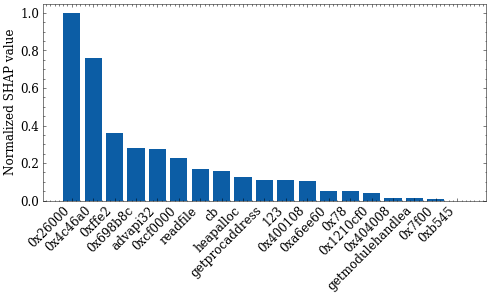

In [ ]:
plt.style.use(['science', 'no-latex'])

# [1:] to exclude kernel32
x = [x[0] for x in top_tp_features][1:]
y = np.array([x[1] for x in top_tp_features][1:])
# normalize y to be within [0, 1]
y = (y - y.min()) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=set_size())
ax.bar(x, y)
ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels([f"{x:.1f}" for x in ax.get_yticks()], fontsize=12)
_ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
plt.tight_layout()

#### False Negative Analysis

In [226]:
agg_shap_tokens_fn = aggregate_values(explanations_fn_trojans, tokenizer.vocab)
top_fn_features = sorted(agg_shap_tokens_fn.items(), key=lambda x: x[1], reverse=False)[:TOP]
top_fn_features

100%|██████████| 59/59 [00:38<00:00,  1.54it/s]


[('<unk>', -3.4750826933813856),
 ('0x0', -0.4561697942875102),
 ('virtualalloc', -0.4203553580302191),
 ('0x40d840', -0.2139045654117409),
 ('0x1', -0.2025904286723161),
 ('c', -0.14099636037979896),
 ('software', -0.1317801041752518),
 ('windows', -0.09893176356273164),
 ('none', -0.07956717538387438),
 ('loadlibrarya', -0.07585440149511748),
 ('initterm', -0.07107282111947673),
 ('p', -0.06713703363087148),
 ('0x1211f84', -0.05680396974659198),
 ('e', -0.04800705155241203),
 ('0x200', -0.04756627332089214),
 ('open', -0.04618052774072504),
 ('0x77000000', -0.04518496044197714),
 ('exe', -0.044771875327477034),
 ('0x4610', -0.04343525984686446),
 ('0x4e4', -0.04238416564191473)]

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


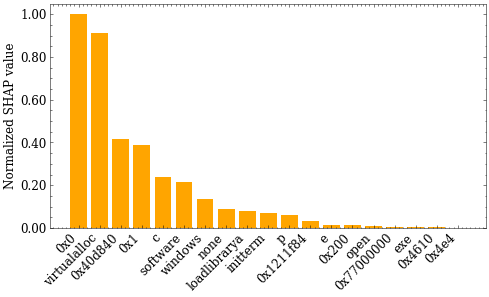

In [263]:
plt.style.use(['science', 'no-latex'])

SKIP = 1
x = [x[0][:20] for x in top_fn_features][SKIP:]
y = np.array([x[1] for x in top_fn_features][SKIP:])
# flip sign for all y
y = -y
# normalize y to be within [0, 1]
y = (y - y.min()) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=set_size())
ax.bar(x, y, color='orange')
ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels([f"{x:.2f}" for x in ax.get_yticks()], fontsize=12)
_ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
plt.tight_layout()

### Run on Goodware

In [266]:
LIMIT = 1000

trojan_folder = os.path.join(REPOSITORY_ROOT, r"data\windows_emulation_testset\report_clean")
# 1000 files takes ~35 mins
files_limited = [os.path.join(trojan_folder, x) for x in os.listdir(trojan_folder)][:LIMIT]

explanations_tp_clean_file = f"explanations_tn_clean_lim_{LIMIT}.pickle"
explanations_fn_clean_file = f"explanations_fp_clean_lim_{LIMIT}.pickle"

if os.path.exists(explanations_tp_clean_file) and os.path.exists(explanations_fn_clean_file):
    with open(explanations_tp_clean_file, "rb") as f:
        explanations_tp_clean = pickle.load(f)
    with open(explanations_fn_clean_file, "rb") as f:
        explanations_fn_clean = pickle.load(f)
else:
    explanations_tp_clean, explanations_fn_clean = generalize_shap_values(
        files_limited,
        model_no_embed,
        x_embed_baseline,
        verbose=False,
        clean=True
    )
    # dump as pickle
    with open(explanations_tp_clean_file, "wb") as f:
        pickle.dump(explanations_tp_clean, f)
    with open(explanations_fn_clean_file, "wb") as f:
        pickle.dump(explanations_fn_clean, f)


In [267]:
agg_shap_tokens_tn = aggregate_values(explanations_tp_clean, tokenizer.vocab)

TOP = 20
top_tn_features = sorted(agg_shap_tokens_tn.items(), key=lambda x: x[1], reverse=True)[:TOP]
top_tn_features

100%|██████████| 616/616 [07:17<00:00,  1.41it/s]


[('kernel32', 82.27785314273456),
 ('0x7090', 12.524490422275143),
 ('advapi32', 2.29972915204224),
 ('heapalloc', 1.5386725977571456),
 ('1', 1.2269150256130719),
 ('0', 0.6486440310271079),
 ('flsalloc', 0.48550485525681336),
 ('flssetvalue', 0.482790317740687),
 ('interlockedexchange', 0.4117229775939205),
 ('0x403004', 0.40536607669885955),
 ('user32', 0.39386989200804257),
 ('getprocessheap', 0.38744729019781426),
 ('0x76c0', 0.3589597261086393),
 ('0xe00', 0.35840386533750956),
 ('0x7770', 0.3232428903200622),
 ('0x7450', 0.2924949560191057),
 ('0x45f0', 0.249067937371789),
 ('0x4640', 0.2439689688702629),
 ('system32', 0.20796973552102466),
 ('getcurrentthreadid', 0.2059721940545441)]

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


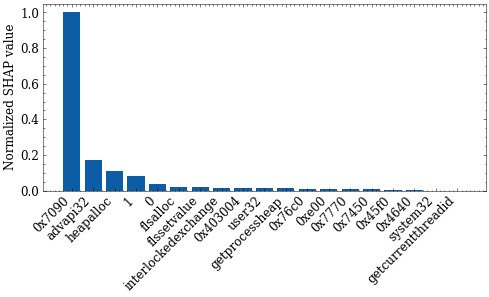

In [268]:
plt.style.use(['science', 'no-latex'])

# [1:] to exclude kernel32
x = [x[0] for x in top_tn_features][1:]
y = np.array([x[1] for x in top_tn_features][1:])
# normalize y to be within [0, 1]
y = (y - y.min()) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=set_size())
ax.bar(x, y)
ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels([f"{x:.1f}" for x in ax.get_yticks()], fontsize=12)
_ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
plt.tight_layout()

#### False Positive Analysis

In [271]:
agg_shap_tokens_fp = aggregate_values(explanations_fn_clean, tokenizer.vocab)
top_fp_features = sorted(agg_shap_tokens_fp.items(), key=lambda x: x[1], reverse=False)[:TOP]
top_fp_features

100%|██████████| 384/384 [04:39<00:00,  1.37it/s]


[('<unk>', -16.46158375625026),
 ('0x1', -2.1925431140035805),
 ('0x77000000', -1.1132076473828387),
 ('0x0', -0.9045773499977322),
 ('none', -0.8079334080685319),
 ('initializecriticalsectionandspincount', -0.6271321161103898),
 ('0xfa0', -0.551235775904401),
 ('getcurrentprocessid', -0.4255108022228183),
 ('0x42ce24', -0.3505904154178401),
 ('virtualalloc', -0.3500893802958794),
 ('0x200', -0.3026935680996176),
 ('dll', -0.2733834747638995),
 ('0xfeee0000', -0.26949196383043056),
 ('c', -0.25260436602511477),
 ('getmodulehandlew', -0.24934142030744),
 ('0x100', -0.24788066339071765),
 ('0xfde9', -0.24345489680843102),
 ('initializecriticalsectionex', -0.2376124235499675),
 ('0xfeee0001', -0.23627598235573583),
 ('getstartupinfow', -0.23355488710235087)]

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


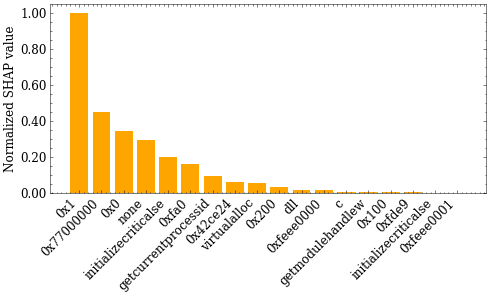

In [272]:
plt.style.use(['science', 'no-latex'])

SKIP = 1
x = [x[0][:20] for x in top_fp_features][SKIP:]
y = np.array([x[1] for x in top_fp_features][SKIP:])
# flip sign for all y
y = -y
# normalize y to be within [0, 1]
y = (y - y.min()) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=set_size())
ax.bar(x, y, color='orange')
ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels([f"{x:.2f}" for x in ax.get_yticks()], fontsize=12)
_ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
plt.tight_layout()

## Diverging Bar Plot For Both Classes

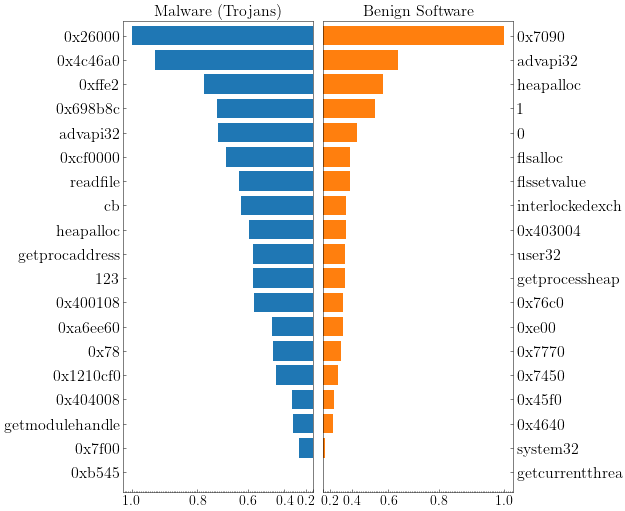

In [273]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['science'])#, 'no-latex'])

def power_transform(x, alpha=0.5):
    return np.power(x, alpha)

def inverse_power_transform(y, alpha=0.5):
    return np.power(y, 1/alpha)

# Extract and normalize positive class data
FEATURE_LIM = 15 # chars
SKIP = 1
x_pos = [x[0][:FEATURE_LIM] for x in top_tp_features][SKIP:]
y_pos = np.array([x[1] for x in top_tp_features][SKIP:])
y_pos = (y_pos - y_pos.min()) / (y_pos.max() - y_pos.min())
y_pos = power_transform(y_pos)

# Extract and normalize negative class data
x_neg = [x[0][:FEATURE_LIM] for x in top_tn_features][SKIP:]
y_neg = np.array([x[1] for x in top_tn_features][SKIP:])
y_neg = (y_neg - y_neg.min()) / (y_neg.max() - y_neg.min())
y_neg = power_transform(y_neg)

# Create a figure and axis
sizes = set_size()
fig, axs = plt.subplots(1, 2, figsize=(sizes[0], sizes[1]*2))  # Adjust the size as needed

ax = axs[0]
# Plot positive values
ax.barh(np.arange(len(x_pos)), y_pos, color='tab:blue', label='Positive', align='edge')

ax.set_yticks(np.arange(len(x_pos)) + 0.4)
ax.set_yticklabels(x_pos, fontsize=16)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_title("Malware (Trojans)", fontsize=16)

ax2 = axs[1]
# # Plot negative values on the second x-axis
ax2.barh(np.arange(len(x_neg)), y_neg, color='tab:orange', label='Negative', align='edge')
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_right()

ax2.set_yticks(np.arange(len(x_neg)) + 0.4)
ax2.set_yticklabels(x_neg, fontsize=16)
ax2.set_title("Benign Software", fontsize=16)

# remove minor yticks
from matplotlib.ticker import NullLocator
ax.yaxis.set_minor_locator(NullLocator())
ax2.yaxis.set_minor_locator(NullLocator())

# # Adjust layout
fig.subplots_adjust(wspace=0.05)

# discarded
# ax.grid(linewidth=0.3)
# ax2.grid(linewidth=0.3)
# plt.tight_layout()

# Get the locations in the transformed scale
original_ticks = ax.get_xticks()
transformed_tick_locations = inverse_power_transform(original_ticks, alpha=0.5)

# Apply to the plot axis
new_ticks = np.round(original_ticks, 2)
new_ticks = [str(x) if x != 0.0 else '' for x in new_ticks]

ax.set_xticks(transformed_tick_locations)
ax.set_xticklabels(new_ticks, fontsize=14)
new_ticks = [str(x) if x != '' else '' for x in new_ticks]
ax2.set_xticks(transformed_tick_locations)
ax2.set_xticklabels(new_ticks, fontsize=14)

ax.set_xlim([0,1.05])
ax.invert_xaxis()

ax.set_ylim([-0.2,19.2])
ax.invert_yaxis()

ax2.set_ylim([-0.2,19.2])
ax2.invert_yaxis()

ax2.set_xlim([0, 1.05])

# save as pdf in img
plt.savefig(os.path.join(REPOSITORY_ROOT, "img", "trojan_benign_shap_values.pdf"), bbox_inches='tight', dpi=300)